In [1]:
import os, sys
import numpy as np
import pandas as pd

import sklearn
import sklearn.metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rc('text', usetex=True)

import time, datetime
import itertools
from joblib import Parallel, delayed
import pickle

In [2]:
data_name = 'alpha'

network_df = pd.read_csv('../rev2data/%s/%s_network.csv' %(data_name, data_name), header=None, names=['src', 'dest', 'rating', 'timestamp'], parse_dates=[3], infer_datetime_format=True)

user_list = ['u' + str(u) for u in network_df['src'].tolist()]

gt_df = pd.read_csv('../rev2data/%s/%s_gt.csv' %(data_name, data_name), header=None, names=['id', 'label'])
gt = dict([('u'+str(x[0]), x[1]) for x in zip(gt_df['id'], gt_df['label'])])

In [3]:
alg_list = ['rev2', 'bad', 'bn', 'trust']

alg_res = {alg_name: pickle.load(open('../%sres/%s.pkl' %(alg_name, data_name), 'rb')) for alg_name in alg_list}

## Computation
+ average precision grid
+ evading grid

In [20]:
def get_metric(ytrue, yscore):
    ytrue[np.where(ytrue > 1)] = 1
    ap = sklearn.metrics.average_precision_score(y_score=yscore, y_true=ytrue)
    auc = sklearn.metrics.roc_auc_score(y_score=yscore, y_true=ytrue)
    # evade_list = [yscore[i] for i in range(len(ulist)) if ulist[i] not in user_list]
    er_num = np.sum(np.bitwise_and(yscore > 0, ytrue > 0))
    er_den = np.sum(ytrue > 0)
    er = er_num / er_den
    return {'ap': ap, 'auc': auc, 'er': er}

def compute_metrics(alg_name, k, n, ind):
    ulist = np.array(alg_res[alg_name][(k, n, ind)]['ulist'])
    yscore = np.array(alg_res[alg_name][(k, n, ind)]['yscore'])
    ytrue = np.array(alg_res[alg_name][(k, n, ind)]['ytrue'])
    fraud_ind = np.where(ytrue != 2)
    fraud_met = get_metric(ytrue=np.copy(ytrue[fraud_ind]), yscore=np.copy(yscore[fraud_ind]))
    sock_ind = np.where(ytrue != 1)
    if np.sum(ytrue[sock_ind]) == 0:
        sock_met = {'ap': 1, 'auc': 1, 'er': 0}
    else:
        sock_met = get_metric(ytrue=np.copy(ytrue[sock_ind]), yscore=np.copy(yscore[sock_ind]))
    comb_met = get_metric(ytrue=np.copy(ytrue), yscore=np.copy(yscore))
    return {'fraud': fraud_met, 'sock': sock_met, 'comb': comb_met}

pkl_path = '../res/%s.pkl' %data_name

if os.path.exists(pkl_path):
    with open(pkl_path, 'rb') as f: metrics_dict = pickle.load(f)
    print('load from %s' %pkl_path)
else:
    print('compute from scratch')
    metrics_dict = {alg_name: Parallel(n_jobs=-1, verbose=3)(delayed(compute_metrics)(alg_name, k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(20))) for alg_name in alg_list}
    # metrics_dict = {alg_name: compute_metrics(alg_name, k, n, ind) for k, n, ind in itertools.product(range(11), range(11), range(20)) for alg_name in alg_list}
    with open(pkl_path, 'wb') as f: pickle.dump(metrics_dict, f)
    print('save to %s' %pkl_path)

compute from scratch


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2420 out of 2420 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   59.4s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Do

save to ../res/alpha.pkl


In [25]:
target_list = ['fraud', 'sock', 'comb']
met_list = ['ap', 'auc', 'er']

plot_data_dict = {alg_name: {t: {m: np.zeros((11, 11, 20)) for m in met_list} for t in target_list} for alg_name in alg_list}

for alg_name, target in itertools.product(alg_list, target_list):
    results_dict = dict(zip(itertools.product(range(11), range(11), range(20)), metrics_dict[alg_name]))
    for k, n, ind in itertools.product(range(11), range(11), range(20)):
        for met in ['ap', 'auc', 'er']:
            plot_data_dict[alg_name][target][met][k, n, ind] = results_dict[(k, n, ind)][target][met]

In [32]:
color_map = {
    'rev2': 'blue',
    'bad': 'orange',
    'bn': 'green',
    'trust': 'red'
}

def plot_lines(ax, x, y_data, ylabel='', xlabel='', title='', e_data=None):
    lines = []
    for alg_name in alg_list:
        y = y_data[alg_name]
        lines += [ax.plot(x, y, marker='x', color=color_map[alg_name])[0]]
        if e_data != None:
            e = e_data[alg_name]
            ax.errorbar(x, y, e, linestyle='None', capsize=2, color=color_map[alg_name])
    ax.set_ylabel(ylabel, fontsize=13)
    ax.set_xlabel(xlabel, fontsize=13)
    ax.set_title(title, fontsize=13)
    return lines

## Vary n

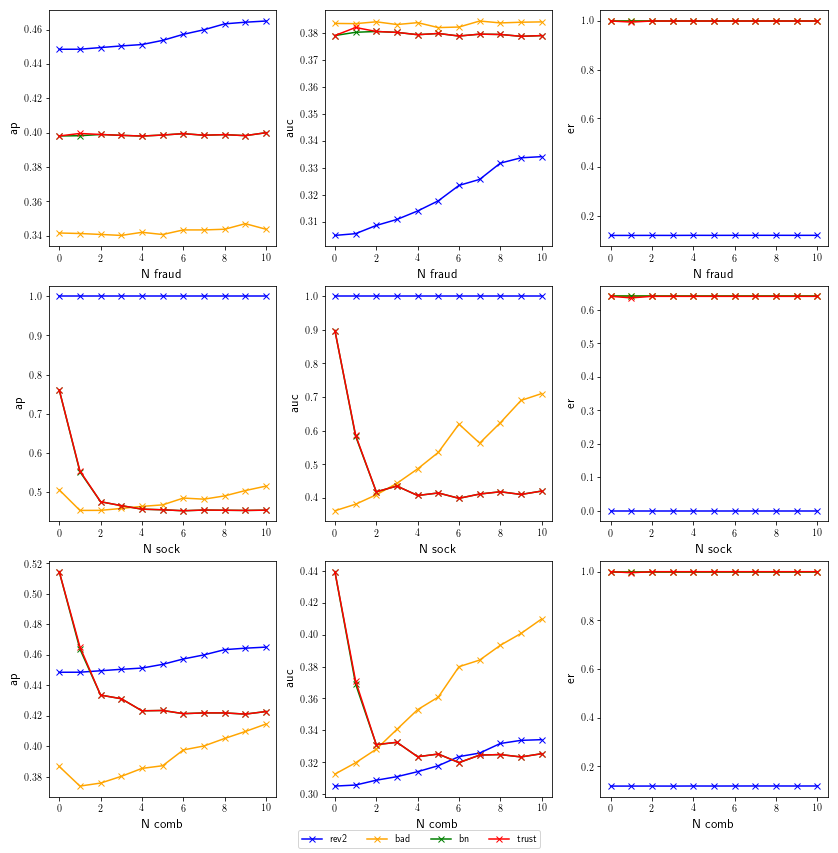

In [39]:
nfig, axes = plt.subplots(3, 3, figsize=(12, 12))

for t_ind, m_ind in itertools.product(range(3), range(3)):
    target = target_list[t_ind]
    met = met_list[m_ind]
    y_data = {alg_name: np.mean(plot_data_dict[alg_name][target][met], axis=(0, 2)) for alg_name in alg_list}
    e_data = {alg_name: np.std(plot_data_dict[alg_name][target][met], axis=(0, 2)) for alg_name in alg_list}
    lines = plot_lines(axes[t_ind, m_ind], range(11), y_data, xlabel='%s %s' %('N', target), ylabel=met, title='', e_data=None)

nfig.tight_layout(pad=2, w_pad=0.3, h_pad=0.2)
nfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

## Vary N given k

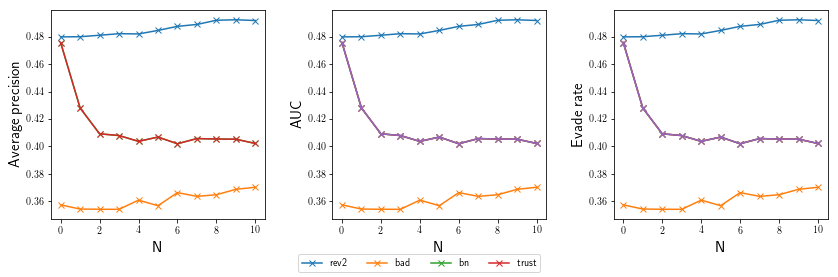

In [11]:
knfig, axes = plt.subplots(1, 3, figsize=(12, 4))

k = 3
ax = axes[0]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    ax.plot(x, y, marker='x')
ax.set_ylabel('Average precision', fontsize=15)
ax.set_xlabel('N', fontsize=15)

ax = axes[1]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    ax.plot(x, y, marker='x')
ax.plot(x, y, marker='x')
ax.set_ylabel('AUC', fontsize=15)
ax.set_xlabel('N', fontsize=15)

lines = []
ax = axes[2]
x = np.arange(11)
for alg_name in alg_list:
    y = np.mean(ap_dict[alg_name], axis=(2))[k, :]
    lines += [ax.plot(x, y, marker='x')[0]]
ax.plot(x, y, marker='x')
ax.set_ylabel('Evade rate', fontsize=15)
ax.set_xlabel('N', fontsize=15)

knfig.tight_layout(pad=2)
knfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list))

## Vary k

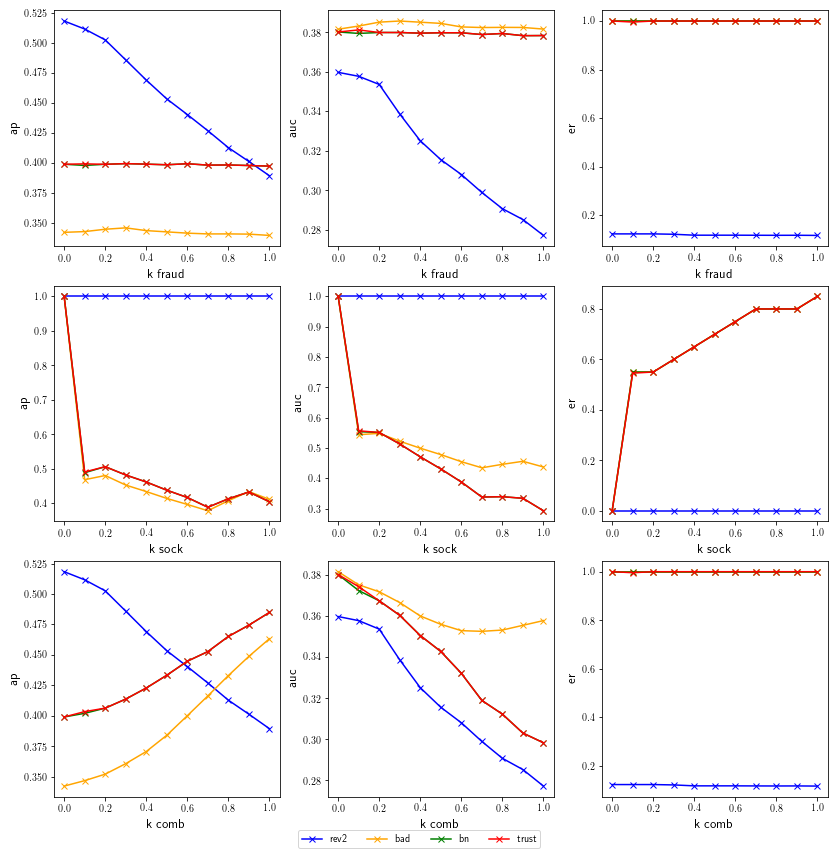

In [43]:
kfig, axes = plt.subplots(3, 3, figsize=(12, 12))

for t_ind, m_ind in itertools.product(range(3), range(3)):
    target = target_list[t_ind]
    met = met_list[m_ind]
    y_data = {alg_name: np.mean(plot_data_dict[alg_name][target][met], axis=(1, 2)) for alg_name in alg_list}
    e_data = {alg_name: np.std(plot_data_dict[alg_name][target][met], axis=(1, 2)) for alg_name in alg_list}
    lines = plot_lines(axes[t_ind, m_ind], np.arange(11)/10, y_data, xlabel='%s %s' %('k', target), ylabel=met, title='', e_data=None)

kfig.tight_layout(pad=2, w_pad=0.3, h_pad=0.2)
kfig.legend(lines, alg_list, loc='lower center', ncol=len(alg_list), fontsize='medium')

In [44]:
nfig.savefig('../rev2fig/%s-n.pdf' %data_name)
kfig.savefig('../rev2fig/%s-k.pdf' %data_name)
# knfig.savefig('../rev2fig/%s-kn.pdf' %data_name)